## Oversampling Notebook



In this notebook we are going to check if we have imbalanced classification in our dataset and proceed to resample and  
adjust the label distribution of the dataset.


Import the modules, set the working directories and load the data.

In [14]:
import numpy as np
import pandas as pd
import datetime
import rasterio
import seaborn as sns
from scipy import stats 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from calendar import monthrange
from calendar import month_name
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imblearn
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder


In [15]:

df = pd.read_csv("../data/main_band_perfield_perDate.csv")

In [3]:
df 

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0
...,...,...,...,...,...,...,...,...,...,...
4301222,122736,2017-11-17,9,23.995344,40.734950,65.776855,92.758230,129.44030,111.960430,0.0
4301223,122736,2017-11-20,9,254.999660,254.366150,251.179920,248.818080,158.32259,111.898240,255.0
4301224,122736,2017-11-22,9,30.892584,45.352844,69.422010,98.832390,139.20786,120.539080,0.0
4301225,122736,2017-11-27,9,25.569672,42.917194,67.971730,94.232460,131.37146,114.247420,0.0


In [4]:
df.shape

(4301227, 10)

In [6]:
df.label.nunique()# number of label

9

make a copy of the dataset and Convert the absolute date to relative date in form of days since april in the new copy

In [16]:
data_df = df.copy()
data_df = data_df.assign(
    date = lambda x: pd.to_datetime(x['date']), 
    #date = lambda x: x['date'].dt.date,
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear,
   
)
data_df.head()

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM,year,month,day,dayofyear
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0,2017,4,1,91
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0,2017,4,11,101
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0,2017,4,21,111
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0,2017,5,1,121
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0,2017,5,11,131


In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301227 entries, 0 to 4301226
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   field_id   int64         
 1   date       datetime64[ns]
 2   label      int64         
 3   B02        float64       
 4   B03        float64       
 5   B04        float64       
 6   B08        float64       
 7   B11        float64       
 8   B12        float64       
 9   CLM        float64       
 10  year       int64         
 11  month      int64         
 12  day        int64         
 13  dayofyear  int64         
dtypes: datetime64[ns](1), float64(7), int64(6)
memory usage: 459.4 MB


A Countplot is created providing a visualization of the label breakdown of the dataset.

This gives a clearer idea that we have a high count of  crop type represented by label 4 than the rest crop types in the dataset

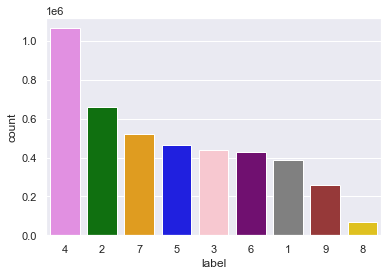

In [18]:
sns.set_theme(style="darkgrid")
custom_palette = ["violet","green","orange","blue","pink","purple","grey","brown","gold"]
sns.set_palette(custom_palette)
ax = sns.countplot(x="label", data=df, order = df['label'].value_counts().index)


we have an underrepresented minority crop type (label 8), oversampling techniques maybe used to duplicate these results for a more balanced amount of positive results in training.
One of the the Oversampling techniques that we will use is SMOTE(Synthetic Minority Over-sampling Technique),which creates synthetic samples by randomly sampling the characteristics from occurrences in the minority label

In [19]:
data_df= data_df.drop(columns=['date'])

In [20]:
data_df

,field_id,label,B02,B03,B04,B08,B11,B12,CLM,year,month,day,dayofyear
0,1,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0,2017,4,1,91
1,1,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0,2017,4,11,101
2,1,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0,2017,4,21,111
3,1,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0,2017,5,1,121
4,1,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0,2017,5,11,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4301222,122736,9,23.995344,40.734950,65.776855,92.758230,129.44030,111.960430,0.0,2017,11,17,321
4301223,122736,9,254.999660,254.366150,251.179920,248.818080,158.32259,111.898240,255.0,2017,11,20,324
4301224,122736,9,30.892584,45.352844,69.422010,98.832390,139.20786,120.539080,0.0,2017,11,22,326
4301225,122736,9,25.569672,42.917194,67.971730,94.232460,131.37146,114.247420,0.0,2017,11,27,331


The imbalanced-learn library provides an implementation of SMOTE that we can use that is compatible with the popular scikit-learn library. Let's apply SMOTE and put all other labels on the same count as the label with the most count.


In [21]:

# split into input and output elements
X= data_df.drop('label',axis=1)
y = data_df['label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


The distribution of examples for each label is then reported, confirming that each label now has 1066136 examples, as we expected.
A bar chart of the label distribution is also created, providing a strong visual indication that all labels now have the same number of examples.

label=3, n=1066136 (11.111%)
label=6, n=1066136 (11.111%)
label=5, n=1066136 (11.111%)
label=7, n=1066136 (11.111%)
label=4, n=1066136 (11.111%)
label=1, n=1066136 (11.111%)
label=8, n=1066136 (11.111%)
label=2, n=1066136 (11.111%)
label=0, n=1066136 (11.111%)


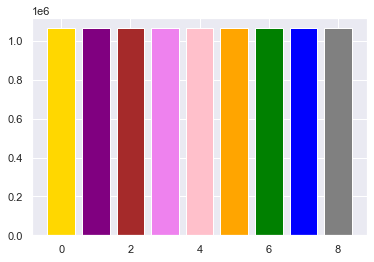

In [22]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('label=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values(),color=["violet","green","orange","blue","pink","purple","grey","brown","gold"])
pyplot.show()
